# AMAZON



### IMPORT ###

In [1]:
!pip install vaderSentiment


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [2]:
import json
import gzip
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline

In [3]:
!mkdir -p data

In [4]:
!wget -O data/Office_Products_5.json.gz https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Office_Products_5.json.gz --no-check-certificate

--2023-12-08 22:57:36--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Office_Products_5.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 111685374 (107M) [application/x-gzip]
Saving to: ‘data/Office_Products_5.json.gz’

data/Office_Product 100%[===================>] 106.51M  41.3MB/s    in 2.6s    

2023-12-08 22:57:39 (41.3 MB/s) - ‘data/Office_Products_5.json.gz’ saved [111685374/111685374]



In [5]:
!pwd

/content


In [6]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


df = getDF('/content/data/Office_Products_5.json.gz')

## DF Amazon Office ##

### Cleaning ###

In [7]:
# we have 800357 rows for amazon fashion reviews and 12 features
df.shape

(800357, 12)

In [8]:
# column names
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')

In [9]:
# first five reviews
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",1510012800,NaN,NaN
1,4.0,True,"03 7, 2017",A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,1488844800,NaN,NaN
2,5.0,True,"06 25, 2016",APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,1466812800,NaN,NaN
3,5.0,True,"02 21, 2016",A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,1456012800,NaN,NaN
4,5.0,False,"08 2, 2015",A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,1438473600,NaN,NaN


In [10]:
# print column types
df.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote               object
image              object
dtype: object

In [11]:
# Let's fix the types of vote, reviewTime, and unixReviewTime

# Replace NaN values with 0
df['vote'] = df['vote'].fillna(0)
# Replace commas and convert to int
df['vote'] = df['vote'].astype(str).str.replace(',', '').astype(int)

In [12]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['convertedReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,convertedReviewTime
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",1510012800,0,NaN,2017-11-06 19:00:00-05:00
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,1488844800,0,NaN,2017-03-06 19:00:00-05:00
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,1466812800,0,NaN,2016-06-24 20:00:00-04:00
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,1456012800,0,NaN,2016-02-20 19:00:00-05:00
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,1438473600,0,NaN,2015-08-01 20:00:00-04:00


In [13]:
# Let's check if all rows in convertedReviewTime have the same hour and timezone
df['hour'] = df['convertedReviewTime'].dt.hour
df['minute'] = df['convertedReviewTime'].dt.minute
df['second'] = df['convertedReviewTime'].dt.second
df['timezone'] = df['convertedReviewTime'].dt.tz
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,convertedReviewTime,hour,minute,second,timezone
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",1510012800,0,NaN,2017-11-06 19:00:00-05:00,19,0,0,US/Eastern
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,1488844800,0,NaN,2017-03-06 19:00:00-05:00,19,0,0,US/Eastern
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,1466812800,0,NaN,2016-06-24 20:00:00-04:00,20,0,0,US/Eastern
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,1456012800,0,NaN,2016-02-20 19:00:00-05:00,19,0,0,US/Eastern
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,1438473600,0,NaN,2015-08-01 20:00:00-04:00,20,0,0,US/Eastern


In [14]:
# Check hour uniqueness
df['hour'].unique()

array([19, 20])

In [15]:
# Check minute uniqueness
df['minute'].unique()

array([0])

In [16]:
# Check second uniqueness
df['second'].unique()

array([0])

In [17]:
# Check timezone uniqueness
df['timezone'].unique()

array([<DstTzInfo 'US/Eastern' LMT-1 day, 19:04:00 STD>], dtype=object)

In [18]:
# Since hour is the only column of the timezones (hrs, mins, secs) with more than 1 unique element, in its case 2 and both are very similar in time 19 and 20.
# I will drop the unixTime
columns_to_drop = ['unixReviewTime', 'convertedReviewTime', 'hour', 'minute', 'second', 'timezone']
df = df.drop(columns=columns_to_drop)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,vote,image
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,NaN
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,0,NaN
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,NaN
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,NaN
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,NaN


In [19]:
# print column types
df.dtypes

overall                float64
verified                  bool
reviewTime      datetime64[ns]
reviewerID              object
asin                    object
style                   object
reviewerName            object
reviewText              object
summary                 object
vote                     int64
image                   object
dtype: object

In [20]:
# Not all vote and image values are NaN
print(df['image'].isna().all())

False


In [21]:
# We see we only have 11302 rows with images
df[~df['image'].isna()]

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,vote,image
331,5.0,True,2016-07-18,A12VDGJCWHS8I3,0486413012,{'Format:': ' Paperback'},liltreeclimber,This is the perfect little notebook to keep in...,Cute and compact notebook,4,[https://images-na.ssl-images-amazon.com/image...
446,5.0,True,2014-05-21,A3KSD50RJUX3PC,0528847112,{'Format:': ' Map'},T. Winegard,"<div id=""video-block-R3HUUQLZI1EFLS"" class=""a-...",Better than I expected!,54,[https://images-na.ssl-images-amazon.com/image...
459,5.0,True,2012-03-10,ATY7KZY3K9VUC,0528847112,{'Format:': ' Map'},Hamdi C.,the Randy Mcnally USA map is a great map for t...,great map!,9,[https://images-na.ssl-images-amazon.com/image...
463,4.0,True,2016-09-07,A2HVJUXRT1RMH,0528959948,{'Format:': ' Map'},Brian Lev,Excellent map with (as expected) very high-qua...,Very Good Map with Some Caveats for Project Use,11,[https://images-na.ssl-images-amazon.com/image...
520,5.0,True,2016-07-26,A25GFROQI59HNC,0545040116,{'Package Quantity:': ' 1'},Amber,This number line is PERFECT! I love that the ...,DON'T HESITATE! It's absolutely perfect.,16,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...
800228,4.0,False,2016-07-16,A2SPV96SGOEO2,B01H65CQIU,{'Color:': ' Stone Grey'},The Travelin&#039; H-Family,"I got this with the hopes of a larger, plastic...","Overall, Pretty Good for Portable Storage",0,[https://images-na.ssl-images-amazon.com/image...
800254,4.0,True,2018-05-17,A345F5RT0H9E1Z,B01HB59G7O,{'Style:': ' 10 Sheets'},Scrappin&#039; in the USA,These are very nice inkjet labels for organiza...,Very nice organizational supply!,3,[https://images-na.ssl-images-amazon.com/image...
800270,2.0,True,2018-09-30,A3IJ44KG1L7XBB,B01HDDD2YW,{'Size:': ' 11x17 Inches'},Cole Hardy,"Frankly, I am not sure what part of this is po...",Thin Piece of Vinyl. Definitely Not Porcelain ...,0,[https://images-na.ssl-images-amazon.com/image...
800285,3.0,False,2016-11-30,A30W69EBQKP7NO,B01HDVPJA4,NaN,haleybop,"If you need a simple organizer, this is fine. ...",this is fine. I'd recommend it for a young pro...,0,[https://images-na.ssl-images-amazon.com/image...


In [22]:
# Convert image column to bool True/False because we are not gonna open each link and display the image
df['image'] = df['image'].notna()
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,vote,image
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,0,False
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False


In [23]:
# print column types
df.dtypes

overall                float64
verified                  bool
reviewTime      datetime64[ns]
reviewerID              object
asin                    object
style                   object
reviewerName            object
reviewText              object
summary                 object
vote                     int64
image                     bool
dtype: object

In [24]:
# We see we only have 88817 rows with votes
df[df['vote']!=0]

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,vote,image
21,4.0,True,2014-06-28,A3INJI4T4U2JJS,0310432065,{'Format:': ' Diary'},WV Owl Gal,That being said ...\nI do like that it keeps a...,Don't Have a Title ...,13,False
30,5.0,True,2016-03-10,A1JOJTCV9WWHGE,0310520347,{'Format:': ' Flexibound'},Muller Family,"<div id=""video-block-R2Y52J3IL4TVEP"" class=""a-...",We LOVE this bible cover,33,False
55,5.0,True,2011-03-23,AI00S9IUGAA0Z,0310806607,{'Format:': ' Misc. Supplies'},MH.,These Bible Book Covers make great covers for ...,Good Boy Scout Handbook Cover,69,False
63,5.0,False,2017-09-09,A1UK9AVCT7J8CF,0310806607,{'Format:': ' Misc. Supplies'},Renee R,I am always on the lookout for cool products t...,Great for Boy Scout Handbook,2,False
74,5.0,True,2015-11-07,A2B2M5YQZPBOA3,0310806607,{'Format:': ' Misc. Supplies'},Sarah Lee,I purchased this for my son's Boy Scout book w...,Fits the Boy Scout with spiral binding book well.,15,False
...,...,...,...,...,...,...,...,...,...,...,...
800208,5.0,True,2017-02-12,A1TIS6WPVAUO0E,B01H4R9M6Y,NaN,Renee,Very nice case for price. Fits all my prismac...,Very nice case for price,2,False
800250,1.0,True,2017-12-01,A21NCIZQ3LWCIF,B01HAJXSA2,{'Size:': ' Dry Erase Board SET'},Ravin DeStorm,not a DRY erase board ... I've only used the m...,NOT a DRY erase!!,2,False
800254,4.0,True,2018-05-17,A345F5RT0H9E1Z,B01HB59G7O,{'Style:': ' 10 Sheets'},Scrappin&#039; in the USA,These are very nice inkjet labels for organiza...,Very nice organizational supply!,3,True
800336,5.0,True,2018-02-21,A17G82DCLSNJ89,B01HGG9P10,NaN,Janice Payne,works great for our badges,Five Stars,5,False


In [25]:
df['vote'].value_counts()

0       711540
2        30295
3        15235
4         8873
5         6002
         ...  
1008         1
268          1
225          1
3100         1
457          1
Name: vote, Length: 464, dtype: int64

In [26]:
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,vote,image
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,0,False
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False


In [27]:
# Add review length to see if there is any correlation with overall review later
df['review_length'] = df['reviewText'].str.split().str.len()

In [28]:
df.dtypes

overall                 float64
verified                   bool
reviewTime       datetime64[ns]
reviewerID               object
asin                     object
style                    object
reviewerName             object
reviewText               object
summary                  object
vote                      int64
image                      bool
review_length           float64
dtype: object

In [29]:
df.shape

(800357, 12)

In [30]:
# Get list of products reviewed
products_reviewed = df['asin'].unique()

In [31]:
len(products_reviewed)

27965

In [32]:
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,vote,image,review_length
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False,19.0
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,0,False,43.0
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False,53.0
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,{'Format:': ' Paperback'},Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False,92.0
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,{'Format:': ' Hardcover'},E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...
800352,5.0,True,2017-09-09,ACHG5QICJCS1F,B01HHLLLIO,{'Size:': ' 6 Rolls'},Anky,Delivered on time and is as expected.,5 stars,0,False,7.0
800353,5.0,True,2017-06-02,A1YB5J8SF6QX3L,B01HHLLLIO,{'Size:': ' 6 Rolls'},DM,worked great.,good stuff,0,False,2.0
800354,5.0,True,2017-04-29,A3N4O7L4HBYJX4,B01HHLLLIO,{'Size:': ' 6 Rolls'},Verdant Treasures,I used to score free UPS 4x6 labels. The blac...,Couldn't be happier with these labels,0,False,122.0
800355,5.0,True,2017-02-21,A2DR3CXSWWLYXY,B01HHLLLIO,{'Size:': ' 6 Rolls'},C. F.,great,Five Stars,0,False,1.0


In [33]:
# Lastly we drop the style column, because each product has different styles
df.drop(columns=['style'], inplace=True)

### Plots ###

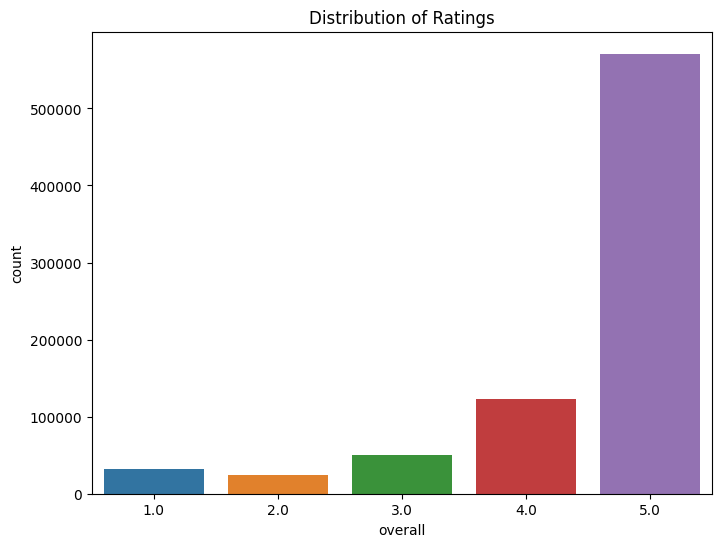

In [34]:
# Distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='overall')
plt.title('Distribution of Ratings')
plt.show()

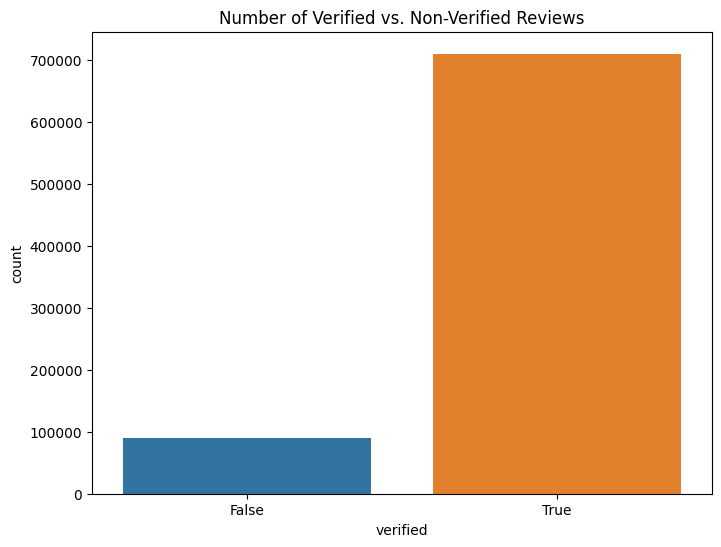

In [35]:
# Number of Verified vs. Non-Verified Reviews
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='verified')
plt.title('Number of Verified vs. Non-Verified Reviews')
plt.show()

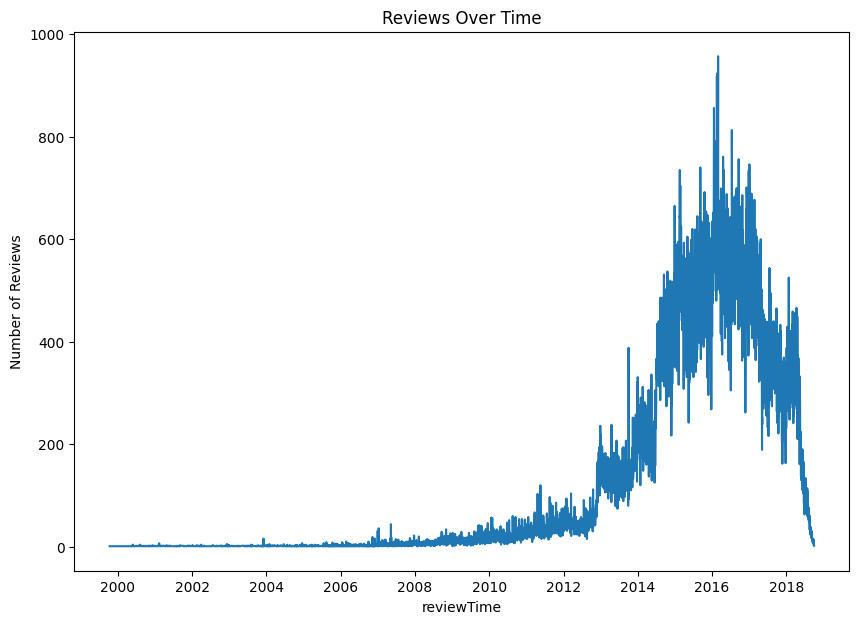

In [36]:
# Reviews over time
plt.figure(figsize=(10, 7))
df_review_date_count = df.groupby(df['reviewTime']).size().reset_index(name="count")
sns.lineplot(data=df_review_date_count, x='reviewTime', y='count')
plt.title('Reviews Over Time')
plt.ylabel('Number of Reviews')
plt.show()

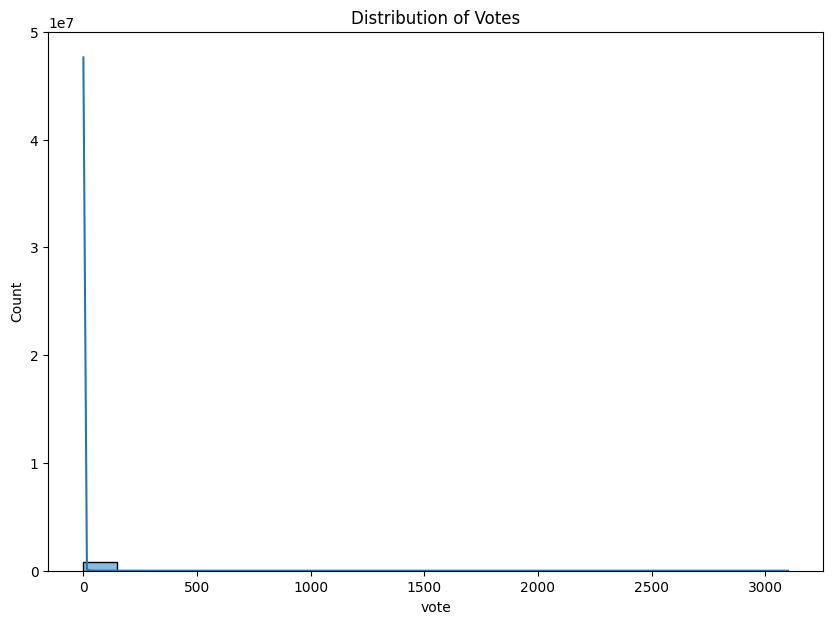

In [37]:
# Vote distribution
plt.figure(figsize=(10, 7))
sns.histplot(data=df, x='vote', kde=True)
plt.title('Distribution of Votes')
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


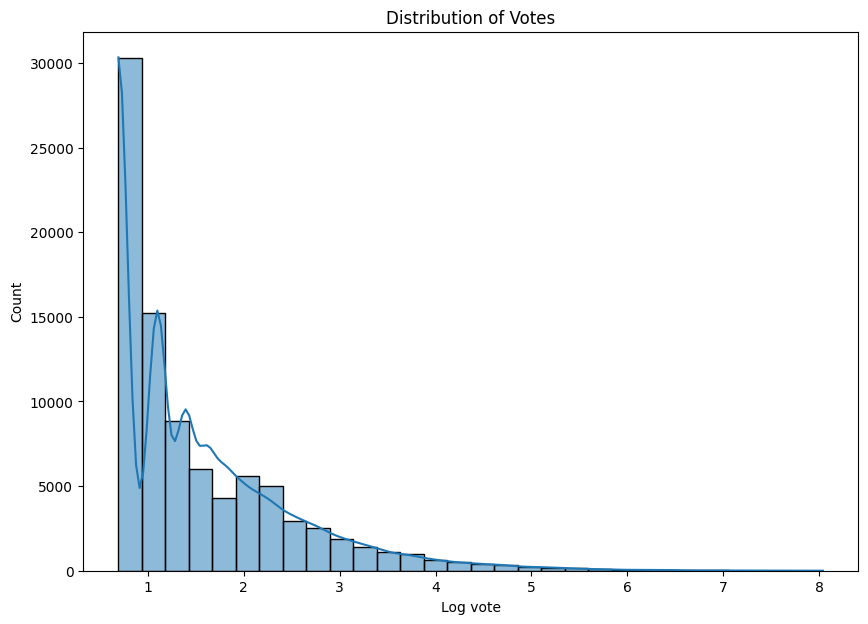

In [38]:
# I decide to take the log since our histogram is skewed.
# Vote distribution using log vote
plt.figure(figsize=(10, 7))
sns.histplot(data=df, x=np.log(df['vote']), kde=True, bins=30)
plt.title('Distribution of Votes')
plt.xlabel('Log vote')
plt.show()
# Conclusion: Most reviews have very few votes.

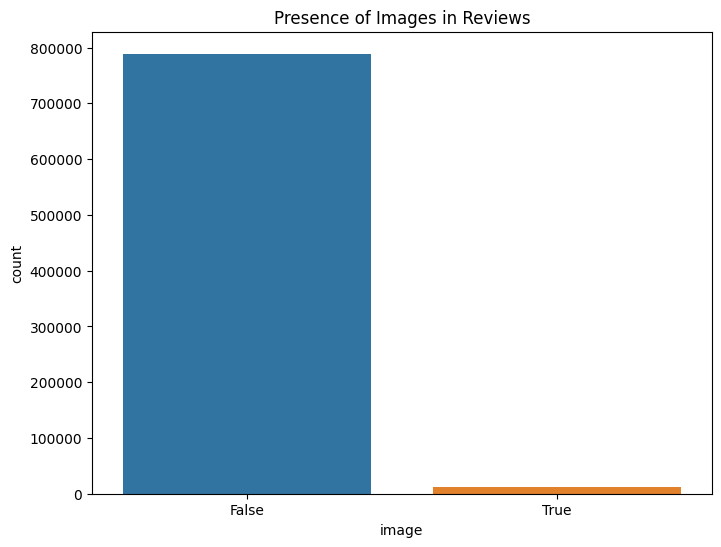

In [39]:
# Image Presence
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='image')
plt.title('Presence of Images in Reviews')
plt.show()

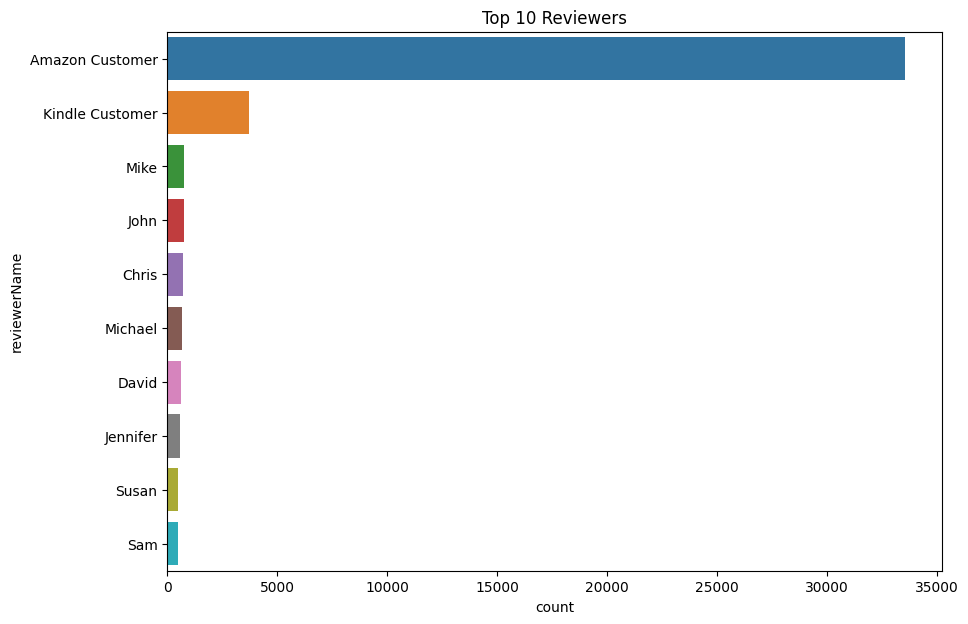

In [40]:
# Top 10 Reviewers
plt.figure(figsize=(10, 7))
sns.countplot(data=df, y='reviewerName', order=df['reviewerName'].value_counts().index[:10])
plt.title('Top 10 Reviewers')
plt.show()

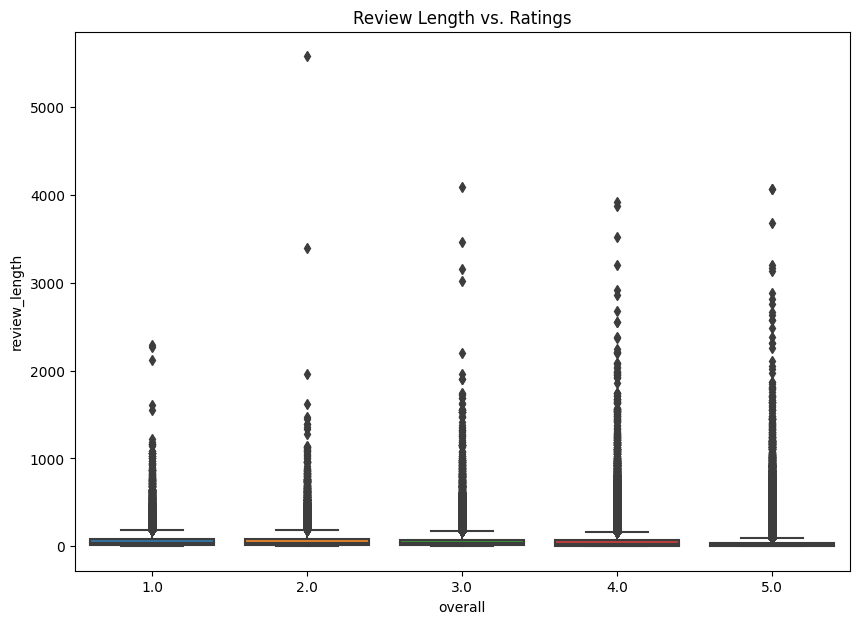

In [41]:
# Review Length and Overall Rating relation
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='overall', y='review_length')
plt.title('Review Length vs. Ratings')
plt.show()

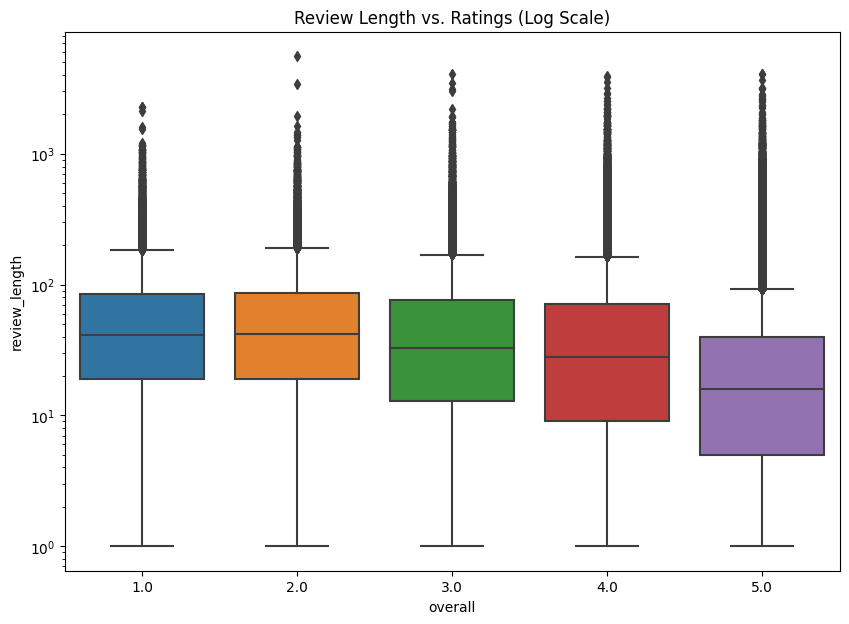

In [42]:
# Again we take the log scale to deal with the outliers
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='overall', y='review_length')
plt.yscale('log')
plt.title('Review Length vs. Ratings (Log Scale)')
plt.show()
# Conclusion: Most high rated products have shorter review length.
# Probably because you have less to say about good product and more to say about bad product.

In [43]:
df.to_csv('/content/data/amazon_office.csv', index=False)

In [44]:
del df

### Review Text ###

In [45]:
df = pd.read_csv('/content/data/amazon_office.csv')

In [46]:
# fill NaN values of review text with empty string
df['reviewText'].fillna('', inplace=True)

In [47]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote,image,review_length
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False,19.0
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,emankcin,Bought this used and it came in great conditio...,Good,0,False,43.0
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False,53.0
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False,92.0
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False,138.0


In [48]:
df.shape

(800357, 11)

In [49]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [50]:
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote,image,review_length
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False,19.0
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,emankcin,Bought this used and it came in great conditio...,Good,0,False,43.0
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False,53.0
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False,92.0
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False,138.0
...,...,...,...,...,...,...,...,...,...,...,...
800352,5.0,True,2017-09-09,ACHG5QICJCS1F,B01HHLLLIO,Anky,Delivered on time and is as expected.,5 stars,0,False,7.0
800353,5.0,True,2017-06-02,A1YB5J8SF6QX3L,B01HHLLLIO,DM,worked great.,good stuff,0,False,2.0
800354,5.0,True,2017-04-29,A3N4O7L4HBYJX4,B01HHLLLIO,Verdant Treasures,I used to score free UPS 4x6 labels. The blac...,Couldn't be happier with these labels,0,False,122.0
800355,5.0,True,2017-02-21,A2DR3CXSWWLYXY,B01HHLLLIO,C. F.,great,Five Stars,0,False,1.0


In [51]:
def analyze_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    return sentiment_score

In [52]:
# Get sentiment score using Vader
df['sentiment_score'] = df['reviewText'].apply(analyze_sentiment)
df.to_csv('/content/data/amazon_office_sentiment.csv', index=False)

In [53]:
df = pd.read_csv('/content/data/amazon_office_sentiment.csv')
df

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote,image,review_length,sentiment_score
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False,19.0,0.6925
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,emankcin,Bought this used and it came in great conditio...,Good,0,False,43.0,0.4767
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False,53.0,0.9169
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False,92.0,0.8789
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False,138.0,0.9848
...,...,...,...,...,...,...,...,...,...,...,...,...
800352,5.0,True,2017-09-09,ACHG5QICJCS1F,B01HHLLLIO,Anky,Delivered on time and is as expected.,5 stars,0,False,7.0,0.0000
800353,5.0,True,2017-06-02,A1YB5J8SF6QX3L,B01HHLLLIO,DM,worked great.,good stuff,0,False,2.0,0.6249
800354,5.0,True,2017-04-29,A3N4O7L4HBYJX4,B01HHLLLIO,Verdant Treasures,I used to score free UPS 4x6 labels. The blac...,Couldn't be happier with these labels,0,False,122.0,0.9143
800355,5.0,True,2017-02-21,A2DR3CXSWWLYXY,B01HHLLLIO,C. F.,great,Five Stars,0,False,1.0,0.6249


In [54]:
# Categorize sentiment scores to 5 classes
def categorize_sentiment(score):
    if score >= 0.6:
        return "very positive"
    elif score >= 0.05 and score < 0.6:
        return "positive"
    elif score > -0.05 and score < 0.05:
        return "neutral"
    elif score <= -0.05 and score > -0.6:
        return "negative"
    else:
        return "very negative"

df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

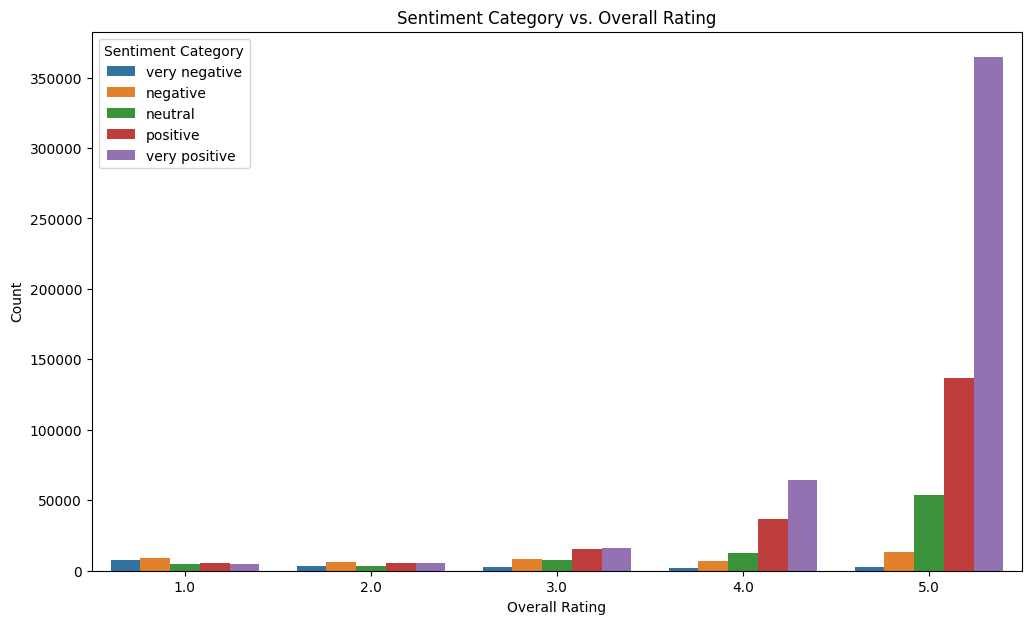

In [55]:
# Plot the sentiment categories vs overall ratings
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='overall', hue='sentiment_category', order=[1.0, 2.0, 3.0, 4.0, 5.0],
              hue_order=['very negative', 'negative', 'neutral', 'positive', 'very positive'])

plt.title('Sentiment Category vs. Overall Rating')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.legend(title='Sentiment Category')
plt.show()


In [56]:
data = df
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote,image,review_length,sentiment_score,sentiment_category
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False,19.0,0.6925,very positive
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,emankcin,Bought this used and it came in great conditio...,Good,0,False,43.0,0.4767,positive
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False,53.0,0.9169,very positive
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False,92.0,0.8789,very positive
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False,138.0,0.9848,very positive


In [57]:
data.groupby('asin').head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote,image,review_length,sentiment_score,sentiment_category
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False,19.0,0.6925,very positive
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,emankcin,Bought this used and it came in great conditio...,Good,0,False,43.0,0.4767,positive
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False,53.0,0.9169,very positive
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False,92.0,0.8789,very positive
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False,138.0,0.9848,very positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
800344,4.0,True,2017-07-02,A2OKG8UA0G4OXS,B01HGYI2F2,Ms.Bane,I would have given this 5 starts except it's h...,Very nice. Just a little hard to open,5,False,71.0,0.1027,positive
800352,5.0,True,2017-09-09,ACHG5QICJCS1F,B01HHLLLIO,Anky,Delivered on time and is as expected.,5 stars,0,False,7.0,0.0000,neutral
800353,5.0,True,2017-06-02,A1YB5J8SF6QX3L,B01HHLLLIO,DM,worked great.,good stuff,0,False,2.0,0.6249,very positive
800354,5.0,True,2017-04-29,A3N4O7L4HBYJX4,B01HHLLLIO,Verdant Treasures,I used to score free UPS 4x6 labels. The blac...,Couldn't be happier with these labels,0,False,122.0,0.9143,very positive


In [58]:
# Attempting to see if there is a correlation between the amount of reviews a user has with the average score they rate products
average_overall_by_reviewer = data.groupby('reviewerID')['overall'].mean()
review_count = data.groupby('reviewerID')['overall'].count()
correlation_data = pd.DataFrame({'Average Overall Score': average_overall_by_reviewer, 'Review Count': review_count})
correlation = correlation_data['Average Overall Score'].corr(correlation_data['Review Count'])
correlation
# The correlation coefficient is 0.038 which indicates that there is little to no correlation between the average overall score given by reviwers and the amount of reviews they have

0.038221077760664454

In [59]:
# Attempting to see if there is a correlation between the amount of reviews a user has with the length of their reviews
review_count = data.groupby('reviewerID').size()
average_length = data.groupby('reviewerID')['review_length'].mean()
correlation = review_count.corr(average_length)
correlation
# The correlation coefficient is 0.1 which suggests a very slight positive correlation between the amount of reviews a reviewer has and the average length of their reviews.

0.10232112717678953

In [60]:
# Attempting to find a correlation between the review length and number of helpful votes (excluding reivews with zero votes)
data_with_votes = data[data['vote'] != 0]
correlation = data_with_votes['review_length'].corr(data_with_votes['vote'])
correlation
# Correlation coefficent is 0.26, which shows a slight positive correlation between review length and the number of helpful votes.
# This implies that there is a slight tendency for longer reviews to recieve more helpful votes.

0.2611883302548994

In [61]:
df.head(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,vote,image,review_length,sentiment_score,sentiment_category
0,4.0,True,2017-11-07,A2NIJTYWADLK57,0140503528,cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",0,False,19.0,0.6925,very positive
1,4.0,True,2017-03-07,A2827D8EEURMP4,0140503528,emankcin,Bought this used and it came in great conditio...,Good,0,False,43.0,0.4767,positive
2,5.0,True,2016-06-25,APB6087F4J09J,0140503528,Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,0,False,53.0,0.9169,very positive
3,5.0,True,2016-02-21,A2DHERRZIPFU7X,0140503528,Caitlyn Jacobson,I purchased this book for my first grade class...,Great for Math!,0,False,92.0,0.8789,very positive
4,5.0,False,2015-08-02,A2XCLJRGFANRC,0140503528,E. Ervin,Having spent numerous years in an elementary s...,Love Corduroy,0,False,138.0,0.9848,very positive


In [62]:
df.to_csv('/content/data/amazon_office_sentiment.csv', index=False)

In [63]:
del df

## Metadata ##

### EDA ###

In [64]:
!wget -O data/meta_Office_Products.json.gz https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Office_Products.json.gz --no-check-certificate

--2023-12-08 23:08:54--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Office_Products.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 511852905 (488M) [application/x-gzip]
Saving to: ‘data/meta_Office_Products.json.gz’

data/meta_Office_Pr 100%[===================>] 488.14M  23.0MB/s    in 12s     

2023-12-08 23:09:07 (39.9 MB/s) - ‘data/meta_Office_Products.json.gz’ saved [511852905/511852905]



In [65]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
%matplotlib inline

In [66]:
# Load 1 line of file into memory at a time
def load_data():
    with gzip.open('/content/data/Office_Products_5.json.gz') as f:
        for l in f:
            yield json.loads(l.strip())

data = load_data()

# List of reviews
subset = []
while True:
    next_item = next(data, None)
    if next_item:
      subset.append(next_item)
    else:
      break

NUM_PRODUCT_ROWS = len(subset)
NUM_PRODUCT_ROWS

800357

In [67]:
# Load 1 line of file into memory at a time
def load_meta():
    with gzip.open('/content/data/meta_Office_Products.json.gz') as f:
        for l in f:
            yield json.loads(l.strip())

meta = load_meta()

# List of product metadata
full_meta = []
while True:
    next_item = next(meta, None)
    if next_item:
      full_meta.append(next_item)
    else:
      break

NUM_META_ROWS = len(full_meta)
NUM_META_ROWS

315458

In [68]:
del data
del meta

In [69]:
# Review structure
print(json.dumps(subset[0], indent=4))

{
    "overall": 4.0,
    "verified": true,
    "reviewTime": "11 7, 2017",
    "reviewerID": "A2NIJTYWADLK57",
    "asin": "0140503528",
    "style": {
        "Format:": " Board book"
    },
    "reviewerName": "cotton clay",
    "reviewText": "kids like story BUT while i really wanted a board book this one is just so small.  wish larger",
    "summary": "good story, small size book though",
    "unixReviewTime": 1510012800
}


In [70]:
# Product metadata structure
print(json.dumps(full_meta[0], indent=4))

{
    "category": [
        "Office Products",
        "Office & School Supplies",
        "Education & Crafts",
        "Early Childhood Education Materials"
    ],
    "tech1": " class=\"a-keyvalue prodDetTable\" role=\"presentation\">\n         \n           \n           \n           \n           <tr>\n            \n            \n              \n              \n               \n                <th class=\"a-color-secondary a-size-base prodDetSectionEntry\">\n                  Brand Name\n                </th>\n                \n              \n            \n            \n           \n            <td class=\"a-size-base\">\n              STL Distributors\n            </td>\n            \n           </tr>\n           \n           \n           \n           <tr>\n            \n            \n              \n              \n               \n                <th class=\"a-color-secondary a-size-base prodDetSectionEntry\">\n                  Item Weight\n                </th>\n               

In [71]:
# Load review subset into dataframe
subset_df = pd.DataFrame.from_dict(subset)
del subset

In [72]:
# Load products metadata into dataframe
meta_df = pd.DataFrame.from_dict(full_meta)
del full_meta

In [73]:
# Raw, unsanitized review structure
subset_df.head(1)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",1510012800,NaN,NaN


In [74]:
# Raw, unsanitized metadata structure
meta_df.head(1)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Office Products, Office & School Supplies, Ed...","class=""a-keyvalue prodDetTable"" role=""present...",[Sequential Spelling is based on the classic O...,,Sequential Spelling Level 1 Bundle with Studen...,[],,STL Distributors,[],"[>#439,654 in Office Products (See top 100), >...","[1935943065, 1935943073, B00IJH9Q4M, 002115021...",Office Products,"class=""a-bordered a-horizontal-stripes a-spa...","August 15, 2014",$32.90,0012624861,[],[],NaN


In [75]:
# Unsanitized metadata column types / counts
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315458 entries, 0 to 315457
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   category         315458 non-null  object
 1   tech1            315458 non-null  object
 2   description      315458 non-null  object
 3   fit              315458 non-null  object
 4   title            315458 non-null  object
 5   also_buy         315458 non-null  object
 6   tech2            315458 non-null  object
 7   brand            315458 non-null  object
 8   feature          315458 non-null  object
 9   rank             315458 non-null  object
 10  also_view        315458 non-null  object
 11  main_cat         315458 non-null  object
 12  similar_item     315458 non-null  object
 13  date             315458 non-null  object
 14  price            315458 non-null  object
 15  asin             315458 non-null  object
 16  imageURL         315458 non-null  object
 17  imageURLHi

In [76]:
# Clean / parse metadata
clean_df = meta_df.copy()

# Redesignate columns from object to string
string_fields = ["category", "description", "fit", "title", "also_buy", "brand", "feature", "rank", "also_view", "main_cat", "date", "asin", "details"]
for string_field in string_fields:
  clean_df[string_field] = meta_df[string_field].astype("string")

# Replace string content of these fields with binary true/false if they are present, since content matters less
# tech1, tech2, similar_item are HTML
# imageURLs are an HTTP links
present_fields = ["tech1", "tech2", "similar_item", "imageURL", "imageURLHighRes"]
for present_field in present_fields:
  # if field is not equal to "[]", mark True
  clean_df[present_field] = meta_df[present_field].str.len() > 2

#
# Wrangle price from $x.xx or <html> 3xklj34 </html> to NaN / Null / int
#

# Replace empty price strings with NaN
clean_df["price"] = meta_df["price"].replace(r'^\s*$', np.nan, regex=True)

# Remove "$" prefix from prices
clean_df["price"] = clean_df["price"].str[1:]

# Replace NaN values with 0, we include products with missing prices so we can keep metadata
clean_df["price"] = clean_df["price"].fillna("0")

# Remove commas from prices, for example, in "$1,234.00"
clean_df["price"] = clean_df["price"].replace(",", "")

# Convert prices to float value, or leave as NaN if unable, despite processing above
clean_df["price"] = pd.to_numeric(clean_df["price"], errors="coerce")

# Not useful
clean_df = clean_df.drop(["fit", "feature"], axis=1)

clean_df.head(2)

,category,tech1,description,title,also_buy,tech2,brand,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"['Office Products', 'Office & School Supplies'...",True,['Sequential Spelling is based on the classic ...,Sequential Spelling Level 1 Bundle with Studen...,[],False,STL Distributors,"['>#439,654 in Office Products (See top 100)',...","['1935943065', '1935943073', 'B00IJH9Q4M', '00...",Office Products,True,"August 15, 2014",32.90,0012624861,False,False,<NA>
1,"['Office Products', 'Office &amp; School Suppl...",False,"['Unusual book', '', '']","Mathematics, Applications and Concepts, Course...",[],False,bailey,"3,839,628 in Books (",[],Books,False,,8.62,0078652669,False,False,<NA>


In [77]:
# Examine structure of metadata after cleaning
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315458 entries, 0 to 315457
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   category         315458 non-null  string 
 1   tech1            315458 non-null  bool   
 2   description      315458 non-null  string 
 3   title            315458 non-null  string 
 4   also_buy         315458 non-null  string 
 5   tech2            315458 non-null  bool   
 6   brand            315458 non-null  string 
 7   rank             315458 non-null  string 
 8   also_view        315458 non-null  string 
 9   main_cat         315458 non-null  string 
 10  similar_item     315458 non-null  bool   
 11  date             315458 non-null  string 
 12  price            312545 non-null  float64
 13  asin             315458 non-null  string 
 14  imageURL         315458 non-null  bool   
 15  imageURLHighRes  315458 non-null  bool   
 16  details          308311 non-null  stri

In [78]:
# Count null prices & highest frequency prices
clean_df["price"].value_counts()

0.00      142745
9.99        4070
8.99        2143
5.99        2066
7.99        2035
           ...  
468.62         1
207.62         1
153.90         1
207.90         1
479.53         1
Name: price, Length: 13903, dtype: int64

In [79]:
# General statistics on product prices
clean_df["price"].describe()

count    312545.000000
mean         18.105199
std          52.186435
min           0.000000
25%           0.000000
50%           4.750000
75%          15.980000
max         999.990000
Name: price, dtype: float64

In [80]:
# Join "reviews" on "metadata" such that each review has associated product info
combined_df_raw = subset_df.merge(clean_df, on="asin")
combined_df_raw.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,brand,rank,also_view,main_cat,similar_item,date,price,imageURL,imageURLHighRes,details
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,{'Format:': ' Board book'},cotton clay,kids like story BUT while i really wanted a bo...,"good story, small size book though",1510012800,...,Ingram Book & Distributor,"['>#422,894 in Office Products (See top 100)',...",['0140501738'],Office Products,False,"September 14, 2006",0.95,False,False,<NA>
1,4.0,True,"03 7, 2017",A2827D8EEURMP4,0140503528,{'Format:': ' Hardcover'},emankcin,Bought this used and it came in great conditio...,Good,1488844800,...,Ingram Book & Distributor,"['>#422,894 in Office Products (See top 100)',...",['0140501738'],Office Products,False,"September 14, 2006",0.95,False,False,<NA>
2,5.0,True,"06 25, 2016",APB6087F4J09J,0140503528,{'Format:': ' Board book'},Starbucks Fan,Every story and book about Corduroy is Fantast...,Best Books for All Children,1466812800,...,Ingram Book & Distributor,"['>#422,894 in Office Products (See top 100)',...",['0140501738'],Office Products,False,"September 14, 2006",0.95,False,False,<NA>


In [81]:
# Remove columns from combined_df not useful to metadata analysis
combined_df = combined_df_raw.drop(["style", "unixReviewTime", "reviewerName", "reviewText", "summary", "vote", "image"], axis=1)

# Redesignate columns from object to stringsv
string_fields = ["reviewTime", "reviewerID", "asin"]
for string_field in string_fields:
  combined_df[string_field] = combined_df_raw[string_field].astype("string")

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914519 entries, 0 to 914518
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   overall          914519 non-null  float64
 1   verified         914519 non-null  bool   
 2   reviewTime       914519 non-null  string 
 3   reviewerID       914519 non-null  string 
 4   asin             914519 non-null  string 
 5   category         914519 non-null  string 
 6   tech1            914519 non-null  bool   
 7   description      914519 non-null  string 
 8   title            914519 non-null  string 
 9   also_buy         914519 non-null  string 
 10  tech2            914519 non-null  bool   
 11  brand            914519 non-null  string 
 12  rank             914519 non-null  string 
 13  also_view        914519 non-null  string 
 14  main_cat         914519 non-null  string 
 15  similar_item     914519 non-null  bool   
 16  date             914519 non-null  stri

### PLOTS ###

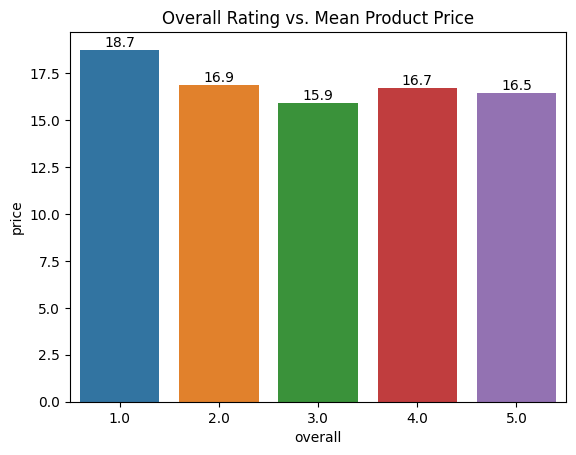

In [82]:
# Examine any correlation between overall rating and price
grouped_by_overall = combined_df.groupby("overall").agg({"overall": "first", "price": "mean"})
ax = sns.barplot(data=grouped_by_overall, x="overall", y="price")
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.title("Overall Rating vs. Mean Product Price")
plt.show()

# Conclusions:
# 1-star reviews are more frequently on higher priced products.
# Perhaps this is due to higher standards for more expensive products.

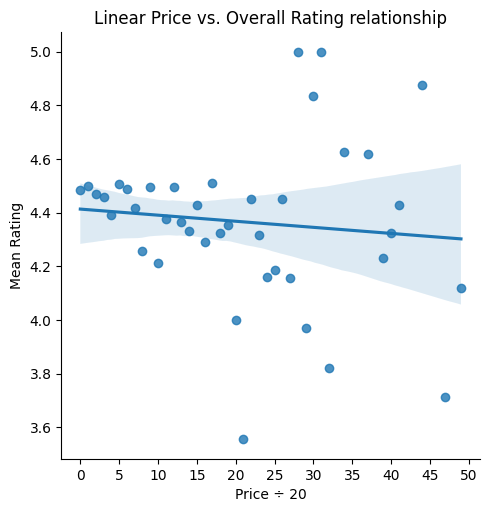

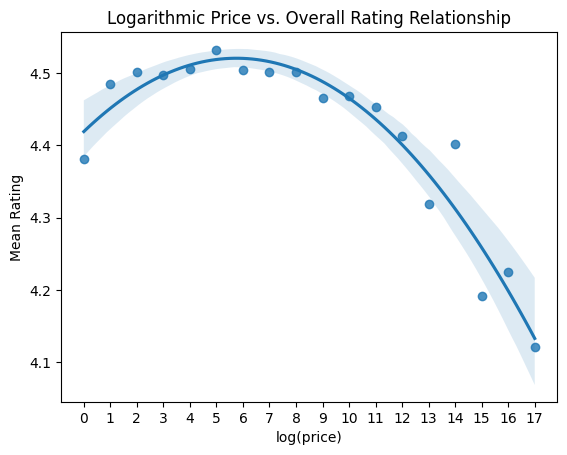

In [83]:
import math

# Group product prices into bins, both linearly and logarithmically
price_bins = combined_df.copy()
price_bins["price_cat"] = price_bins["price"] // 20
price_bins["price_log"] = np.emath.logn(1.5, price_bins["price"]+1) // 1

# Find average product reviews within each price bin
price_bins_norm = price_bins.groupby("price_cat").agg({"price_cat": "first", "overall": "mean", "asin": "count"})

price_bins_log = price_bins.groupby("price_log").agg({"price_log": "first", "overall": "mean", "asin": "count"})

# Examine any linear correlation between price and rating
ax = sns.lmplot(price_bins_norm, x="price_cat", y="overall", fit_reg=True)
ax.set(xlabel='Price ÷ 20', ylabel='Mean Rating')
plt.xticks(range(0, 51, 5))
plt.title("Linear Price vs. Overall Rating relationship")
plt.show()

# Examine any higher order correlation between price and rating
ax = sns.regplot(price_bins_log, x="price_log", y="overall", order=2)
ax.set(xlabel='log(price)', ylabel='Mean Rating')
plt.xticks(range(0, 18))
plt.title("Logarithmic Price vs. Overall Rating Relationship")
plt.show()

# Findings:
# Binning products into evenly spaced groups isn't a great fit, due to less data points in the higher price range
# Binning products into logarithmic groups seems to make more sense, as the difference between a $5 and $35 product is large
# However the difference between a $905 and $935 product is minimal

# Conclusions:
# As price increases, overall ratings tend to decrease, perhaps due to higher standards
# Ratings seem to peak in the $5-20 price range, before decreasing on either end
# Very cheap <$5 products seem to fetch lower ratings, as well as very expensive products

In [84]:
# Examine linear price category vs. rating relationship, as well as product counts
price_bins_norm["actual_price_min"] = price_bins_norm["price_cat"] * 20
price_bins_norm["actual_price_max"] = price_bins_norm["price_cat"] * 20 + 20
price_bins_norm.head(20)

,price_cat,overall,asin,actual_price_min,actual_price_max
price_cat,,,,,
0.0,0.0,4.483909,711225,0.0,20.0
1.0,1.0,4.497631,111024,20.0,40.0
2.0,2.0,4.469255,28850,40.0,60.0
3.0,3.0,4.459607,12824,60.0,80.0
4.0,4.0,4.391596,6568,80.0,100.0
5.0,5.0,4.504919,4676,100.0,120.0
6.0,6.0,4.487362,2532,120.0,140.0
7.0,7.0,4.418733,1452,140.0,160.0
8.0,8.0,4.255834,1157,160.0,180.0


In [85]:
# Examine logarithmic price category vs. rating relationship, as well as product counts
price_bins_log["actual_price_min"] = 1.5 ** price_bins_log["price_log"]
price_bins_log["actual_price_max"] = 1.5 ** (price_bins_log["price_log"] + 1)
price_bins_log.head(20)

,price_log,overall,asin,actual_price_min,actual_price_max
price_log,,,,,
0.0,0.0,4.380987,156034,1.000000,1.500000
1.0,1.0,4.484496,516,1.500000,2.250000
2.0,2.0,4.501111,6753,2.250000,3.375000
3.0,3.0,4.497279,43913,3.375000,5.062500
4.0,4.0,4.505358,113846,5.062500,7.593750
5.0,5.0,4.531945,177276,7.593750,11.390625
6.0,6.0,4.504133,145049,11.390625,17.085938
7.0,7.0,4.501613,108781,17.085938,25.628906
8.0,8.0,4.501490,63096,25.628906,38.443359


In [86]:
# Free memory
import gc
gc.collect()

7780

In [87]:
# Examine unique reviewers and most popular reviewer
combined_df["reviewerID"].value_counts()
combined_df["reviewerID"].describe()

count             914519
unique            101501
top       A3TTVIQ9RRHNIB
freq                 382
Name: reviewerID, dtype: object

In [88]:
# Count products with most reviews
combined_df["asin"].value_counts()

B00006IEEV    4516
B00006IFEU    3774
B00006IFI5    3712
B00006JNJD    3472
B00006IFJ0    2966
              ... 
B0014KM4EK       1
B0010ZPPLS       1
B001602TO8       1
B000X45MR4       1
B0011FEIRE       1
Name: asin, Length: 27932, dtype: Int64

In [89]:
# Extract "year" from "reviewTime"
combined_df["year"] = combined_df["reviewTime"].str[-4:]

# Find most popular review years
combined_df["year"].value_counts()

2016    230284
2015    202761
2017    161459
2014    129082
2013     63412
2018     63344
2012     24572
2011     15468
2010      9054
2009      6106
2008      3501
2007      2142
2006      1013
2005       710
2004       526
2003       358
2002       302
2001       217
2000       206
1999         2
Name: year, dtype: Int64

In [90]:
# Limit to products with at least 2000 reviews
k10_pre = combined_df.groupby("asin").filter(lambda sf: len(sf) > 2000)

# Limit to products/years with at least 100 reviews in a given year
k10 = k10_pre.groupby(["asin", "year"]).filter(lambda sf: len(sf) > 100)
k10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38145 entries, 12240 to 403938
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   overall          38145 non-null  float64
 1   verified         38145 non-null  bool   
 2   reviewTime       38145 non-null  string 
 3   reviewerID       38145 non-null  string 
 4   asin             38145 non-null  string 
 5   category         38145 non-null  string 
 6   tech1            38145 non-null  bool   
 7   description      38145 non-null  string 
 8   title            38145 non-null  string 
 9   also_buy         38145 non-null  string 
 10  tech2            38145 non-null  bool   
 11  brand            38145 non-null  string 
 12  rank             38145 non-null  string 
 13  also_view        38145 non-null  string 
 14  main_cat         38145 non-null  string 
 15  similar_item     38145 non-null  bool   
 16  date             38145 non-null  string 
 17  price  

In [91]:
# Examine reviews by year for a given product, use verified as proxy for total count
k10_prod_yr = k10.groupby(["asin", "year"]).agg({"asin": "first", "year": "first", "overall": "mean", "verified": "count"})

# Only look at reviews after 2013, since there is less data for pre-2013
k10_prod_yr["year"] = np.maximum(k10_prod_yr["year"].astype(int), 2013)
k10_prod_yr.head(5)

asin  year   overall  verified
asin       year                                      
B00000JRRD 2013  B00000JRRD  2013  4.235294       136
           2014  B00000JRRD  2014  4.137255       306
           2015  B00000JRRD  2015  4.430147       544
           2016  B00000JRRD  2016  4.510490       572
           2017  B00000JRRD  2017  4.444444       288

In [92]:
# How many products meet the criteria of >2k reviews and >100/yr?
k10_prod_yr.info()

# Find products with the most high-review years
k10_prod_yr["asin"].value_counts()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77 entries, ('B00000JRRD', '2013') to ('B0015ASS3U', '2017')
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   asin      77 non-null     string 
 1   year      77 non-null     int64  
 2   overall   77 non-null     float64
 3   verified  77 non-null     int64  
dtypes: float64(1), int64(2), string(1)
memory usage: 2.8+ KB


B000ZHB2HS    8
B00006IEEV    6
B00006IFEU    6
B00006IFI5    6
B00006IFJ0    6
B00006JNJD    6
B00006JNNS    6
B00000JRRD    5
B00005249G    5
B00006IAKM    5
B00006IE7J    5
B00006IFAY    5
B0010JEJPC    5
B0015ASS3U    3
Name: asin, dtype: Int64

In [93]:
# Examine how ratings change for one product over a given year
one_product = k10_prod_yr[k10_prod_yr["asin"].str.startswith("B000ZHB2HS")]
one_product.head(10)

asin  year   overall  verified
asin       year                                      
B000ZHB2HS 2011  B000ZHB2HS  2013  4.246154       130
           2012  B000ZHB2HS  2013  4.230769       104
           2013  B000ZHB2HS  2013  4.186047       258
           2014  B000ZHB2HS  2014  4.324786       234
           2015  B000ZHB2HS  2015  4.465517       348
           2016  B000ZHB2HS  2016  4.507772       386
           2017  B000ZHB2HS  2017  4.328767       438
           2018  B000ZHB2HS  2018  4.367742       155

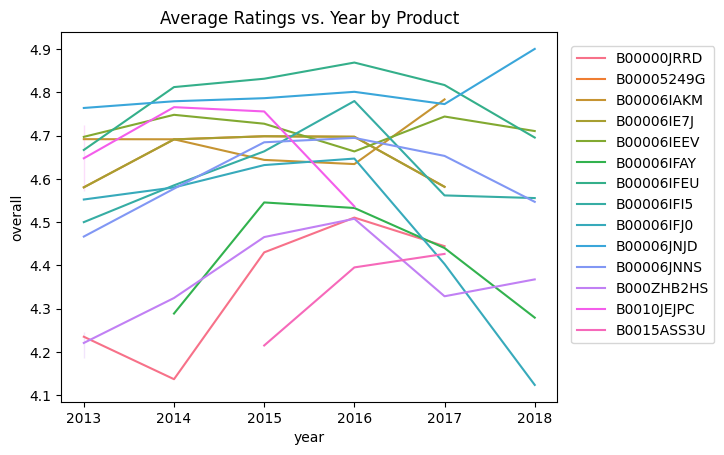

In [94]:
# Examine how ratings change among top products over multiple years
sns.lineplot(data=k10_prod_yr, x="year", y="overall", hue="asin")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=1)
plt.title("Average Ratings vs. Year by Product")
plt.show()

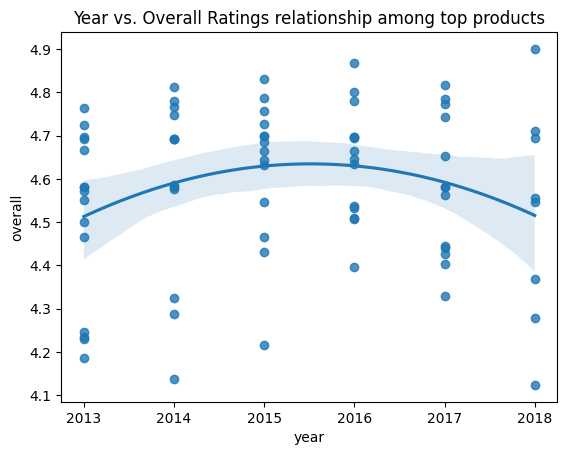

In [95]:
# Examine how ratings change over the years among top products
sns.regplot(data=k10_prod_yr, x="year", y="overall", order=2)
plt.title("Year vs. Overall Ratings relationship among top products")
plt.show()

In [96]:
# Extract description length from product metadata
with_len = combined_df.copy()
with_len["desc_len"] = with_len["description"].str.len().astype("float")
with_len.head(1)

,overall,verified,reviewTime,reviewerID,asin,category,tech1,description,title,also_buy,...,also_view,main_cat,similar_item,date,price,imageURL,imageURLHighRes,details,year,desc_len
0,4.0,True,"11 7, 2017",A2NIJTYWADLK57,0140503528,"['Office Products', 'Office & School Supplies'...",True,['Corduroy the bear goes to the launderette wi...,A Pocket for Corduroy,"['0140501738', '0448421917', '0670063428', '04...",...,['0140501738'],Office Products,False,"September 14, 2006",0.95,False,False,<NA>,2017,241.0


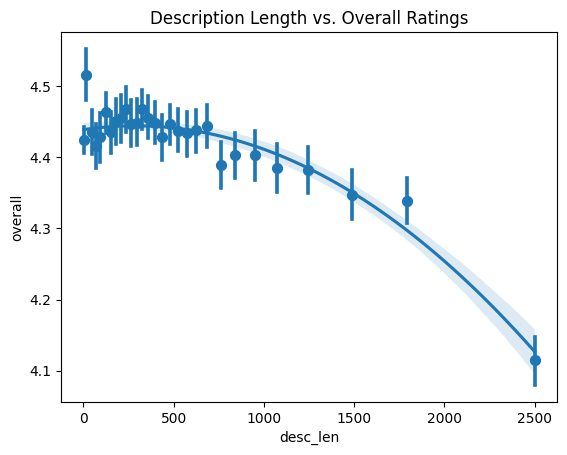

In [97]:
# Group reviews into bins by product, find description length and overall rating averages
len_grp = with_len.groupby(["asin"]).agg({"asin": "first", "desc_len": "mean", "overall": "mean"})

# Cap description length at 2500 words to eliminate random outliers
len_grp["desc_len"] = np.minimum(len_grp["desc_len"], 2500)

# Examine relationship between description length and overall ratings
sns.regplot(len_grp, x="desc_len", x_bins=30, y="overall", order=2)
plt.title("Description Length vs. Overall Ratings")
plt.show()

# Findings:
# As description lengths increase to very high values, average ratings decrease

# Conclusions:
# Perhaps sub-par products with less brand recognition or quality tend to word-vomit in their descriptions

In [98]:
# Examine whether the presence of an image affects product reviews
by_image = combined_df.groupby(["imageURL", "imageURLHighRes"]).agg({"overall": "mean", "verified": "count"})
by_image.head()

,,overall,verified
imageURL,imageURLHighRes,,
False,False,4.445151,344164
True,True,4.508324,570355


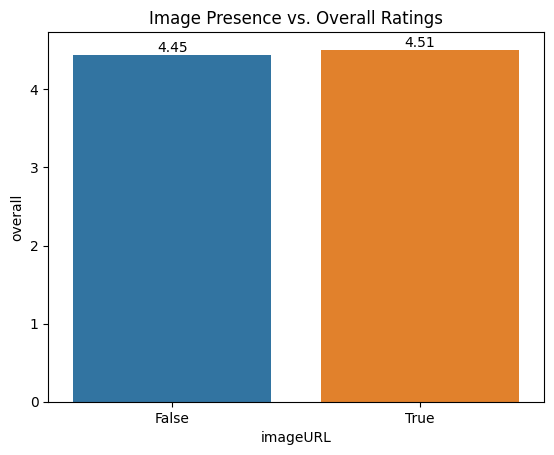

In [99]:
# Plot description length vs overall ratings
ax = sns.barplot(by_image.reset_index(), x="imageURL", y="overall")
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title("Image Presence vs. Overall Ratings")
plt.show()

# Conclusion:
# Including an image in a product slightly increases overall ratings

In [100]:
# Examine statistics for verified reviews
combined_df[combined_df["verified"] == True]["overall"].describe()

count    812089.000000
mean          4.513724
std           0.977077
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [101]:
# Examine statistics for unverified reviews (anonymous, or no confirmed purchase)
combined_df[combined_df["verified"] == False]["overall"].describe()

count    102430.000000
mean          4.253246
std           1.158696
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

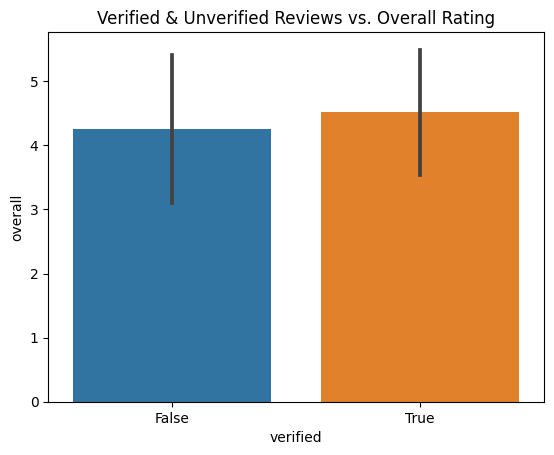

In [102]:
# Examine differences between verified and unverified reviews on ratings
ax = sns.barplot(combined_df, x="verified", y="overall", errorbar="sd")
plt.title("Verified & Unverified Reviews vs. Overall Rating")
plt.show()

# Conclusion:
# Verified reviews tend to be higher rating than unverified reviews
# Verified reviews tend to deviate less than unverified reviews

In [103]:
# Examine overall review deviations; stdev: 1.00
combined_df["overall"].describe()

count    914519.000000
mean          4.484550
std           1.002433
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [104]:
# Examine overall review deviations only with reviewers with more than 30 reviews
# stdev: 0.84
multi_review = combined_df.groupby("reviewerID").filter(lambda sf: len(sf) > 30)
multi_review["overall"].describe()

count    68320.000000
mean         4.550132
std          0.845371
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [105]:
# Let's look at how much deviation there is within one reviewer's ratings, rather than across reviewers
# mean stdev: 0.66
multi_reviewer_dev = multi_review.groupby("reviewerID")["overall"].std()
multi_reviewer_dev.describe()

count    1453.000000
mean        0.664755
std         0.377041
min         0.000000
25%         0.428155
50%         0.673390
75%         0.905858
max         1.754889
Name: overall, dtype: float64

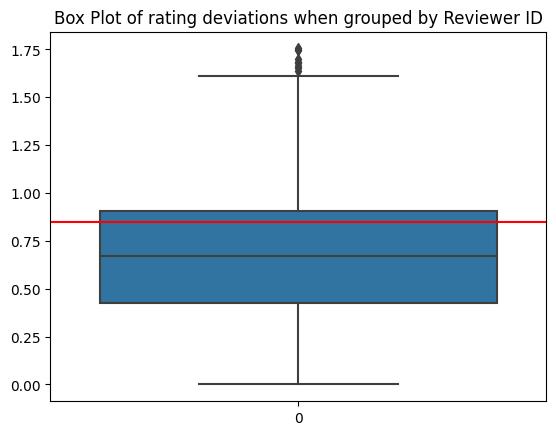

In [106]:
# Plot deviation within individuals' reviews against deviation across all reviews
sns.boxplot(multi_reviewer_dev)

# General population stdev to compare to
plt.axhline(y=0.85, color="red")

plt.title("Box Plot of rating deviations when grouped by Reviewer ID")
plt.show()

# Conclusions:
# Individuals seem to deviate less in their own ratings compared to ratings of other individuals
# In other words, people that leave low reviews tend to leave low reviews in the future

In [107]:
# Examine deviation in prices within reviewers
# mean stdev: 24
multi_reviwer_price_dev = multi_review.groupby("reviewerID")["price"].std()
multi_reviwer_price_dev.describe()

count    1453.000000
mean       23.962522
std        24.334433
min         2.879025
25%         9.604341
50%        15.485556
75%        28.911107
max       216.426283
Name: price, dtype: float64

In [108]:
# Examine mean/deviation in prices across all reviewers vs. reviewers with many reviews
# mean stdev: 35
(
    combined_df["price"].mean(),
    combined_df["price"].std(),
    multi_review["price"].mean(),
    multi_review["price"].std()
)

# Conclusions:
# People tend to buy similarly priced products compared to what they've already bought
# (within individual price stdev: 24, across individuals price stdev: 35)

(16.567951155267345, 35.09169960111453, 15.894464561679948, 35.71026750074249)

## Modeling ##

### Import ###

In [109]:
%reset -f
# Manage Memory
import json
import gzip
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [110]:
sentiment_data = pd.read_csv('/content/data/amazon_office_sentiment.csv')
print(sentiment_data.shape)
meta_df = getDF('/content/data/meta_Office_Products.json.gz')
print(meta_df.shape)

combined_df = sentiment_data.merge(meta_df, on="asin", how="inner")
del sentiment_data
del meta_df

combined_df = combined_df.drop(
    ["feature", "similar_item", "main_cat", "category", "tech1", "details", "tech2", "similar_item", "also_buy", "title", "also_view", "fit", "reviewerID", "brand", "reviewerName", "reviewText", "summary"],
    axis=1
)

combined_df.shape

(800357, 13)
(315458, 19)


(914519, 15)

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

### Cleaning ###

In [112]:
# Combined_df structure and columns
print(combined_df.info())
combined_df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914519 entries, 0 to 914518
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   overall             914519 non-null  float64
 1   verified            914519 non-null  bool   
 2   reviewTime          914519 non-null  object 
 3   asin                914519 non-null  object 
 4   vote                914519 non-null  int64  
 5   image               914519 non-null  bool   
 6   review_length       914275 non-null  float64
 7   sentiment_score     914519 non-null  float64
 8   sentiment_category  914519 non-null  object 
 9   description         914519 non-null  object 
 10  rank                914519 non-null  object 
 11  date                914519 non-null  object 
 12  price               914519 non-null  object 
 13  imageURL            914519 non-null  object 
 14  imageURLHighRes     914519 non-null  object 
dtypes: bool(2), float64(3), int64(1), 

,overall,verified,reviewTime,asin,vote,image,review_length,sentiment_score,sentiment_category,description,rank,date,price,imageURL,imageURLHighRes
0,4.0,True,2017-11-07,0140503528,0,False,19.0,0.6925,very positive,[Corduroy the bear goes to the launderette wit...,"[>#422,894 in Office Products (See top 100), >...","September 14, 2006",$0.95,[],[]
1,4.0,True,2017-03-07,0140503528,0,False,43.0,0.4767,positive,[Corduroy the bear goes to the launderette wit...,"[>#422,894 in Office Products (See top 100), >...","September 14, 2006",$0.95,[],[]
2,5.0,True,2016-06-25,0140503528,0,False,53.0,0.9169,very positive,[Corduroy the bear goes to the launderette wit...,"[>#422,894 in Office Products (See top 100), >...","September 14, 2006",$0.95,[],[]


In [113]:
clean_df = combined_df.drop(["rank",  "description"], axis=1)

present_fields = ["imageURL", "imageURLHighRes"]
for present_field in present_fields:
  # if field is not equal to "[]", mark True
  clean_df[present_field] = clean_df[present_field].str.len() > 2

# Redesignate columns from object to string
string_fields = ["date", "price", "reviewTime", "asin", "sentiment_category"]
for string_field in string_fields:
  clean_df[string_field] = clean_df[string_field].astype("string")

clean_df.head(3)

,overall,verified,reviewTime,asin,vote,image,review_length,sentiment_score,sentiment_category,date,price,imageURL,imageURLHighRes
0,4.0,True,2017-11-07,0140503528,0,False,19.0,0.6925,very positive,"September 14, 2006",$0.95,False,False
1,4.0,True,2017-03-07,0140503528,0,False,43.0,0.4767,positive,"September 14, 2006",$0.95,False,False
2,5.0,True,2016-06-25,0140503528,0,False,53.0,0.9169,very positive,"September 14, 2006",$0.95,False,False


In [114]:
#
# Wrangle price from $x.xx or <html> 3xklj34 </html> to NaN / Null / int
#
# Replace empty price strings with NaN
clean_df["price"] = combined_df["price"].replace(r'^\s*$', np.nan, regex=True)
# Replace NaN values with 0, we include products with missing prices so we can keep metadata
clean_df["price"] = clean_df["price"].fillna("$0")
# Remove "$" prefix from prices
clean_df["price"] = clean_df["price"].str[1:]
# Remove commas from prices, for example, in "$1,234.00"
clean_df["price"] = clean_df["price"].str.replace(",", "")
# Convert prices to float value, or leave as NaN if unable, despite processing above
clean_df["price"] = pd.to_numeric(clean_df["price"], errors="coerce")

clean_df["desc_len"] = combined_df["description"].str.len().astype("float")

clean_df["rank"] = combined_df["rank"].astype(str).str[4:]
clean_df["rank"] = clean_df["rank"].str.replace(',','')
clean_df["rank"] = clean_df["rank"].str.extract('^(\d+)')
clean_df["rank"] = clean_df["rank"].astype("float")
clean_df.head(1)

,overall,verified,reviewTime,asin,vote,image,review_length,sentiment_score,sentiment_category,date,price,imageURL,imageURLHighRes,desc_len,rank
0,4.0,True,2017-11-07,0140503528,0,False,19.0,0.6925,very positive,"September 14, 2006",0.95,False,False,1.0,422894.0


In [115]:
clean_df.to_csv('/content/data/sentiment_meta_join.csv', index=False)

### Models ###

In [116]:
%reset -f
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [118]:
original_data = pd.read_csv('/content/data/sentiment_meta_join.csv').head(250000)

# Train into training and testing (We only use testing at the very end)
data, preserved_test_data = train_test_split(original_data, test_size=0.01, random_state=42)
print(data.shape)
print(preserved_test_data.shape)

(247500, 15)
(2500, 15)


#### Feature Selection and Removing Outliers ####

In [119]:
from sklearn.metrics import accuracy_score, classification_report

# We use the random forest classifier to choose our features
# We look at highest accuracy for each subset of features to choose features for our final model

def evaluate_model(data, features):

    # Extract X and y from data
    X = data[features]
    y = data['overall']

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Impute missing values using the mean
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_val_scaled = scaler.transform(X_val_imputed)

    # Fit the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = rf.predict(X_val_scaled)

    # Calculate Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)

    # Print Accuracy
    print(f"Accuracy of the RandomForestClassifier model: {accuracy:.2f}")
    print(report)


In [120]:
features1 = ['review_length']
evaluate_model(data, features1)

Accuracy of the RandomForestClassifier model: 0.76
              precision    recall  f1-score   support

         1.0       0.26      0.00      0.01      1345
         2.0       0.37      0.01      0.01      1139
         3.0       0.46      0.01      0.01      2629
         4.0       0.47      0.01      0.02      6950
         5.0       0.76      1.00      0.86     37437

    accuracy                           0.76     49500
   macro avg       0.46      0.20      0.18     49500
weighted avg       0.68      0.76      0.65     49500



In [121]:
features2 = ['sentiment_score']
evaluate_model(data, features2)

Accuracy of the RandomForestClassifier model: 0.77
              precision    recall  f1-score   support

         1.0       0.52      0.32      0.40      1345
         2.0       0.55      0.20      0.29      1139
         3.0       0.47      0.15      0.23      2629
         4.0       0.43      0.08      0.14      6950
         5.0       0.79      0.98      0.88     37437

    accuracy                           0.77     49500
   macro avg       0.55      0.35      0.39     49500
weighted avg       0.71      0.77      0.71     49500



In [122]:
features3 = ['vote', 'sentiment_score']
evaluate_model(data, features3)

Accuracy of the RandomForestClassifier model: 0.78
              precision    recall  f1-score   support

         1.0       0.59      0.43      0.50      1345
         2.0       0.63      0.28      0.38      1139
         3.0       0.55      0.20      0.29      2629
         4.0       0.52      0.13      0.20      6950
         5.0       0.80      0.97      0.88     37437

    accuracy                           0.78     49500
   macro avg       0.62      0.40      0.45     49500
weighted avg       0.74      0.78      0.73     49500



In [123]:
features4 = ['review_length', 'sentiment_score']
evaluate_model(data, features4)

Accuracy of the RandomForestClassifier model: 0.83
              precision    recall  f1-score   support

         1.0       0.73      0.59      0.66      1345
         2.0       0.71      0.53      0.61      1139
         3.0       0.67      0.44      0.53      2629
         4.0       0.69      0.36      0.47      6950
         5.0       0.85      0.96      0.90     37437

    accuracy                           0.83     49500
   macro avg       0.73      0.58      0.63     49500
weighted avg       0.81      0.83      0.81     49500



In [124]:
features5 = ['vote', 'review_length', 'sentiment_score']
evaluate_model(data, features5)

Accuracy of the RandomForestClassifier model: 0.83
              precision    recall  f1-score   support

         1.0       0.74      0.64      0.69      1345
         2.0       0.74      0.54      0.63      1139
         3.0       0.67      0.44      0.53      2629
         4.0       0.70      0.37      0.48      6950
         5.0       0.86      0.96      0.91     37437

    accuracy                           0.83     49500
   macro avg       0.74      0.59      0.65     49500
weighted avg       0.82      0.83      0.81     49500



In [125]:
features6 = ['verified', 'vote', 'review_length', 'sentiment_score']
evaluate_model(data, features6)

Accuracy of the RandomForestClassifier model: 0.84
              precision    recall  f1-score   support

         1.0       0.75      0.66      0.71      1345
         2.0       0.74      0.56      0.64      1139
         3.0       0.70      0.46      0.56      2629
         4.0       0.72      0.38      0.50      6950
         5.0       0.86      0.97      0.91     37437

    accuracy                           0.84     49500
   macro avg       0.76      0.61      0.66     49500
weighted avg       0.83      0.84      0.82     49500



In [126]:
# removes outliers from sentiment_score using IQR to find outliers
def remove_outliers_sentiment(group):
    Q1 = group['sentiment_score'].quantile(0.25)
    Q3 = group['sentiment_score'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['sentiment_score'] >= lower_bound) & (group['sentiment_score'] <= upper_bound)]

In [127]:
data_no_outliers = data.copy()
data_no_outliers = data_no_outliers.groupby('asin').apply(remove_outliers_sentiment)
data_no_outliers = data_no_outliers.reset_index(drop=True)
data_no_outliers.shape

(238814, 15)

In [128]:
def remove_outliers_overall(group):
    Q1 = group['overall'].quantile(0.25)
    Q3 = group['overall'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['overall'] >= lower_bound) & (group['overall'] <= upper_bound)]

In [129]:
data_no_outliers.groupby('asin').apply(remove_outliers_overall)
data_no_outliers = data_no_outliers.reset_index(drop=True)
data_no_outliers.shape
# No outliers regarding overall column removed

(238814, 15)

In [130]:
evaluate_model(data_no_outliers, features6)
# filtering out outliers using IQR did not produce much meaningful results

Accuracy of the RandomForestClassifier model: 0.85
              precision    recall  f1-score   support

         1.0       0.81      0.61      0.69       999
         2.0       0.74      0.55      0.63       873
         3.0       0.71      0.46      0.56      2358
         4.0       0.73      0.38      0.50      6731
         5.0       0.86      0.97      0.91     36802

    accuracy                           0.85     47763
   macro avg       0.77      0.59      0.66     47763
weighted avg       0.83      0.85      0.83     47763



In [131]:
# removes outliers from sentiment_score
def remove_outliers_zscore(df, col, z_score_threshold=2):
  col_mean = df[col].mean()
  col_std = df[col].std()
  z_score = (df[col] - col_mean) / col_std
  outliers = np.abs(z_score) > z_score_threshold
  return df[~outliers]


In [132]:
#check shape before taking out outliers
data_z_score_outliers = data.copy()
data_z_score_outliers.shape

(247500, 15)

In [133]:
data_z_score_outliers = data_z_score_outliers.groupby('asin').apply(remove_outliers_zscore, col='sentiment_score')
data_z_score_outliers = data_z_score_outliers.reset_index(drop=True)
data_z_score_outliers.shape
#shape after outliers were taken out

(236685, 15)

In [134]:
data_z_score_outliers = data_z_score_outliers.groupby('asin').apply(remove_outliers_zscore, col='overall')
data_z_score_outliers = data_z_score_outliers.reset_index(drop=True)
data_z_score_outliers.shape
# interestingly, using z-score to find outliers within 'overall' produced outliers when IQR did not find any

(223202, 15)

In [135]:
evaluate_model(data_z_score_outliers, features6)
# filtering out outliers according to z-score produced signifcantly higher accuracy as well

Accuracy of the RandomForestClassifier model: 0.87
              precision    recall  f1-score   support

         1.0       0.81      0.72      0.76       169
         2.0       0.79      0.49      0.60       176
         3.0       0.76      0.44      0.56      1160
         4.0       0.75      0.38      0.50      6450
         5.0       0.89      0.98      0.93     36686

    accuracy                           0.87     44641
   macro avg       0.80      0.60      0.67     44641
weighted avg       0.86      0.87      0.86     44641



In [136]:
data_zs_img = data_z_score_outliers.copy()
data_zs_img["image_int"] = data_zs_img["image"].astype(int)

features7 = ['sentiment_score', 'verified', 'vote', 'review_length', 'image_int']
evaluate_model(data_zs_img, features7)
# No meaningful improvement by checking presence of review image

Accuracy of the RandomForestClassifier model: 0.87
              precision    recall  f1-score   support

         1.0       0.81      0.69      0.74       169
         2.0       0.77      0.49      0.60       176
         3.0       0.76      0.44      0.56      1160
         4.0       0.75      0.38      0.51      6450
         5.0       0.89      0.98      0.93     36686

    accuracy                           0.87     44641
   macro avg       0.79      0.60      0.67     44641
weighted avg       0.86      0.87      0.86     44641



In [137]:
features8 = ['sentiment_score', 'verified', 'vote', 'review_length', 'desc_len']
evaluate_model(data_z_score_outliers, features8)

Accuracy of the RandomForestClassifier model: 0.88
              precision    recall  f1-score   support

         1.0       0.84      0.73      0.78       169
         2.0       0.86      0.56      0.68       176
         3.0       0.77      0.49      0.60      1160
         4.0       0.77      0.43      0.55      6450
         5.0       0.89      0.98      0.93     36686

    accuracy                           0.88     44641
   macro avg       0.83      0.64      0.71     44641
weighted avg       0.87      0.88      0.87     44641



In [138]:
features9 = ['sentiment_score', 'verified', 'vote', 'review_length', 'desc_len', 'price']
evaluate_model(data_z_score_outliers, features9)

Accuracy of the RandomForestClassifier model: 0.91
              precision    recall  f1-score   support

         1.0       0.89      0.77      0.83       169
         2.0       0.94      0.64      0.76       176
         3.0       0.88      0.64      0.74      1160
         4.0       0.84      0.61      0.71      6450
         5.0       0.93      0.98      0.95     36686

    accuracy                           0.91     44641
   macro avg       0.89      0.73      0.80     44641
weighted avg       0.91      0.91      0.91     44641



In [139]:
features10 = ['sentiment_score', 'verified', 'vote', 'review_length', 'desc_len', 'price', 'imageURL']
evaluate_model(data_z_score_outliers, features10)

Accuracy of the RandomForestClassifier model: 0.92
              precision    recall  f1-score   support

         1.0       0.92      0.79      0.85       169
         2.0       0.85      0.64      0.73       176
         3.0       0.87      0.65      0.74      1160
         4.0       0.84      0.62      0.72      6450
         5.0       0.93      0.98      0.95     36686

    accuracy                           0.92     44641
   macro avg       0.88      0.73      0.80     44641
weighted avg       0.91      0.92      0.91     44641



In [140]:
features11 = ['sentiment_score', 'verified', 'vote', 'review_length', 'desc_len', 'price', 'imageURL', 'rank']
evaluate_model(data_z_score_outliers, features11)

Accuracy of the RandomForestClassifier model: 0.92
              precision    recall  f1-score   support

         1.0       0.93      0.82      0.87       169
         2.0       0.91      0.65      0.76       176
         3.0       0.90      0.67      0.77      1160
         4.0       0.87      0.64      0.74      6450
         5.0       0.93      0.98      0.96     36686

    accuracy                           0.92     44641
   macro avg       0.91      0.75      0.82     44641
weighted avg       0.92      0.92      0.92     44641



Therefore our selected features are features11 as they result in highest accuracy, precision and recall.

In [141]:
features = features11

#### Model Selection ####

In [142]:
# Removing outliers from training set and validation set (will only be using it to determine final model)
# Will not use this modified set for our final model

data_z_score_outliers = data.copy()
data_z_score_outliers.shape

data_z_score_outliers = data_z_score_outliers.groupby('asin').apply(remove_outliers_zscore, col='sentiment_score')
data_z_score_outliers = data_z_score_outliers.reset_index(drop=True)
data_z_score_outliers.shape

data_z_score_outliers = data_z_score_outliers.groupby('asin').apply(remove_outliers_zscore, col='overall')
data_z_score_outliers = data_z_score_outliers.reset_index(drop=True)
print(data_z_score_outliers.shape)

(223202, 15)


In [143]:
# Define a function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy_test = accuracy_score(y_test, y_pred)
    report_test = classification_report(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train)

    # Print model performance
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy on Training: {accuracy_train:.2f}")
    print(report_train)
    print("-" * 60)
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy on Validation: {accuracy_test:.2f}")
    print(report_test)
    print("-" * 60)

In [144]:
# Evaluating our models for dataset with outliers removed, we use 40,000 samples or else very slowly models come out

new_data = data_z_score_outliers.copy().sample(40000)

X_model_selection = new_data[features]
y_model_selection = new_data['overall']

# Split the data into training and validation sets
X_train_model_selection, X_val_model_selection, y_train_model_selection, y_val_model_selection = train_test_split(X_model_selection, y_model_selection, test_size=0.2, random_state=42)

# Impute missing values using the mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed_model_selection = imputer.fit_transform(X_train_model_selection)
X_val_imputed_model_selection = imputer.transform(X_val_model_selection)

# Scale the features
scaler = StandardScaler()
X_train_scaled_model_selection = scaler.fit_transform(X_train_imputed_model_selection)
X_val_scaled_model_selection = scaler.transform(X_val_imputed_model_selection)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
train_and_evaluate_model(log_reg, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

# Support Vector Classifier
svm_clf = SVC(random_state=42)
train_and_evaluate_model(svm_clf, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

# K-Nearest Neighbors
knn_clf = KNeighborsClassifier()
train_and_evaluate_model(knn_clf, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

# Gradient Boosting Classifier
gbc_clf = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gbc_clf, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

# Multi-layer Perceptron classifier
mlp_clf = MLPClassifier(random_state=42, max_iter=1000)
train_and_evaluate_model(mlp_clf, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(rf, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LogisticRegression
Accuracy on Training: 0.82
              precision    recall  f1-score   support

         1.0       0.49      0.24      0.32       136
         2.0       0.00      0.00      0.00       161
         3.0       0.22      0.01      0.02       891
         4.0       0.36      0.01      0.02      4494
         5.0       0.83      1.00      0.90     26318

    accuracy                           0.82     32000
   macro avg       0.38      0.25      0.25     32000
weighted avg       0.74      0.82      0.75     32000

------------------------------------------------------------
Model: LogisticRegression
Accuracy on Validation: 0.82
              precision    recall  f1-score   support

         1.0       0.50      0.25      0.33        24
         2.0       0.00      0.00      0.00        36
         3.0       0.56      0.02      0.05       210
         4.0       0.17      0.00      0.01      1161
         5.0       0.82      1.00      0.90      6569

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: SVC
Accuracy on Training: 0.83
              precision    recall  f1-score   support

         1.0       0.76      0.38      0.50       136
         2.0       1.00      0.07      0.13       161
         3.0       1.00      0.02      0.03       891
         4.0       0.96      0.01      0.01      4494
         5.0       0.83      1.00      0.90     26318

    accuracy                           0.83     32000
   macro avg       0.91      0.29      0.32     32000
weighted avg       0.85      0.83      0.75     32000

------------------------------------------------------------
Model: SVC
Accuracy on Validation: 0.82
              precision    recall  f1-score   support

         1.0       0.43      0.12      0.19        24
         2.0       0.00      0.00      0.00        36
         3.0       1.00      0.00      0.01       210
         4.0       0.00      0.00      0.00      1161
         5.0       0.82      1.00      0.90      6569

    accuracy                           0.82   

In [152]:
# Evaluating our models for dataset with outliers removed, we use 40,000 samples or else very slowly models come out

new_data = data_z_score_outliers.copy()

X_model_selection = new_data[features]
y_model_selection = new_data['overall']

# Split the data into training and validation sets
X_train_model_selection, X_val_model_selection, y_train_model_selection, y_val_model_selection = train_test_split(X_model_selection, y_model_selection, test_size=0.2, random_state=42)

# Impute missing values using the mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_imputed_model_selection = imputer.fit_transform(X_train_model_selection)
X_val_imputed_model_selection = imputer.transform(X_val_model_selection)

# Scale the features
scaler = StandardScaler()
X_train_scaled_model_selection = scaler.fit_transform(X_train_imputed_model_selection)
X_val_scaled_model_selection = scaler.transform(X_val_imputed_model_selection)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
train_and_evaluate_model(log_reg, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

# K-Nearest Neighbors
knn_clf = KNeighborsClassifier()
train_and_evaluate_model(knn_clf, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(rf, X_train_scaled_model_selection, y_train_model_selection, X_val_scaled_model_selection, y_val_model_selection)

Model: LogisticRegression
Accuracy on Training: 0.82
              precision    recall  f1-score   support

         1.0       0.41      0.20      0.27       646
         2.0       0.00      0.00      0.00       765
         3.0       0.17      0.00      0.01      4761
         4.0       0.34      0.01      0.02     25739
         5.0       0.82      1.00      0.90    146650

    accuracy                           0.82    178561
   macro avg       0.35      0.24      0.24    178561
weighted avg       0.73      0.82      0.75    178561

------------------------------------------------------------
Model: LogisticRegression
Accuracy on Validation: 0.82
              precision    recall  f1-score   support

         1.0       0.38      0.18      0.24       169
         2.0       0.00      0.00      0.00       176
         3.0       0.16      0.00      0.01      1160
         4.0       0.31      0.01      0.02      6450
         5.0       0.82      1.00      0.90     36686

    accuracy    

As we can see, since Random Forest Classifier has the highest validation accuracy, we will use it for our final modeling.

## Final run with original, unmanipulated test data

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def train_and_evaluate_final_model(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Define class labels
    class_labels = [str(float(i)) for i in range(1, 6)]  # Labels from 1.0 to 5.0

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Number of observations', rotation=270, labelpad=20)

    plt.show()

    # Evaluate the model
    accuracy_test = accuracy_score(y_test, y_pred)
    report_test = classification_report(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train)

    # Print model performance
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy on Training: {accuracy_train:.2f}")
    print(report_train)
    print("-" * 60)
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy on Testing: {accuracy_test:.2f}")
    print(report_test)
    print("-" * 60)


In [147]:
final_data = data.copy()
final_data.shape

final_data = final_data.groupby('asin').apply(remove_outliers_zscore, col='sentiment_score')
final_data = final_data.reset_index(drop=True)
final_data.shape

final_data = final_data.groupby('asin').apply(remove_outliers_zscore, col='overall')
final_data = final_data.reset_index(drop=True)
print(final_data.shape)

X_final_train = final_data[features]
y_final_train = final_data['overall']

# Impute missing values using the mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_final_train_imputed = imputer.fit_transform(X_final_train)
X_final_test_imputed = imputer.transform(preserved_test_data[features])

# Scale the features
scaler = StandardScaler()
X_final_train_scaled = scaler.fit_transform(X_final_train_imputed)
X_final_test_scaled = scaler.transform(X_final_test_imputed)

y_final_test = preserved_test_data['overall']

(223202, 15)


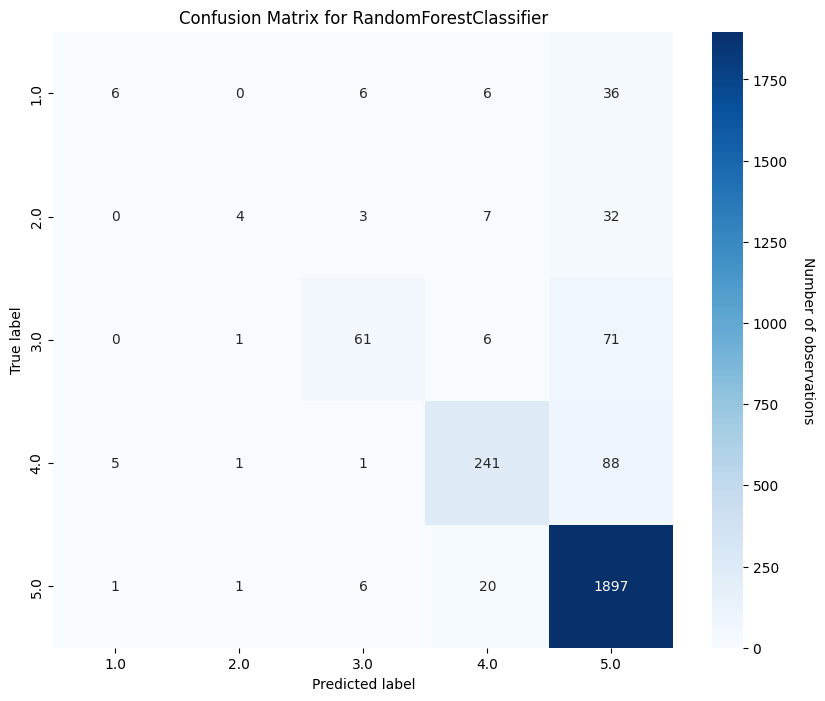

Model: RandomForestClassifier
Accuracy on Training: 0.98
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       815
         2.0       0.99      0.98      0.99       941
         3.0       0.98      0.94      0.96      5921
         4.0       0.97      0.88      0.92     32189
         5.0       0.98      0.99      0.99    183336

    accuracy                           0.98    223202
   macro avg       0.98      0.96      0.97    223202
weighted avg       0.98      0.98      0.98    223202

------------------------------------------------------------
Model: RandomForestClassifier
Accuracy on Testing: 0.88
              precision    recall  f1-score   support

         1.0       0.50      0.11      0.18        54
         2.0       0.57      0.09      0.15        46
         3.0       0.79      0.44      0.56       139
         4.0       0.86      0.72      0.78       336
         5.0       0.89      0.99      0.94      1925

    accurac

In [148]:
rf = RandomForestClassifier(n_estimators=100)
train_and_evaluate_final_model(rf, X_final_train_scaled, y_final_train, X_final_test_scaled, y_final_test)

### 3.0 & 5.0 Constant Model ###

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def train_and_evaluate_final_model_constant(X_train, y_train, X_test, y_test, number):

    # Make predictions
    y_pred_train = [number for _ in range(len(X_train))]
    y_pred = [number for _ in range(len(X_test))]

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Define class labels
    class_labels = [str(float(i)) for i in range(1, 6)]  # Labels from 1.0 to 5.0

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {number} model')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Number of observations', rotation = 270, labelpad = 20)

    plt.show()

    # Evaluate the model
    accuracy_test = accuracy_score(y_test, y_pred)
    report_test = classification_report(y_test, y_pred)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train)

    # Print model performance
    print(f"Model:")
    print(f"Accuracy on Training: {accuracy_train:.2f}")
    print(report_train)
    print("-" * 60)
    print(f"Model:")
    print(f"Accuracy on Testing: {accuracy_test:.2f}")
    print(report_test)
    print("-" * 60)


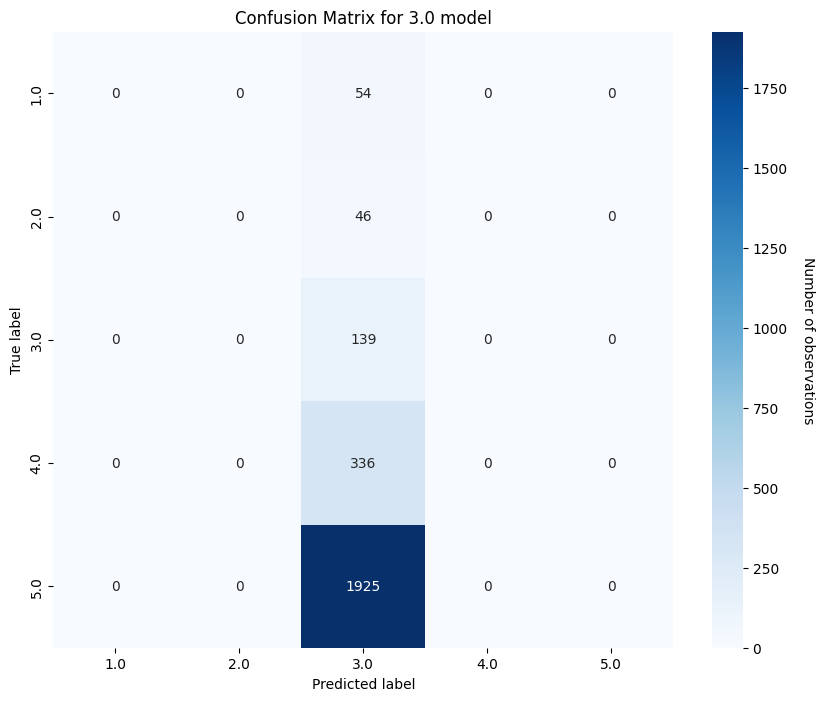

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Model:
Accuracy on Training: 0.03
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       815
         2.0       0.00      0.00      0.00       941
         3.0       0.03      1.00      0.05      5921
         4.0       0.00      0.00      0.00     32189
         5.0       0.00      0.00      0.00    183336

    accuracy                           0.03    223202
   macro avg       0.01      0.20      0.01    223202
weighted avg       0.00      0.03      0.00    223202

------------------------------------------------------------
Model:
Accuracy on Testing: 0.06
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        54
         2.0       0.00      0.00      0.00        46
         3.0       0.06      1.00      0.11       139
         4.0       0.00      0.00      0.00       336
         5.0       0.00      0.00      0.00      1925

    accuracy                           0.06      2500
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [150]:
train_and_evaluate_final_model_constant(X_final_train_scaled, y_final_train, X_final_test_scaled, y_final_test, 3.0)

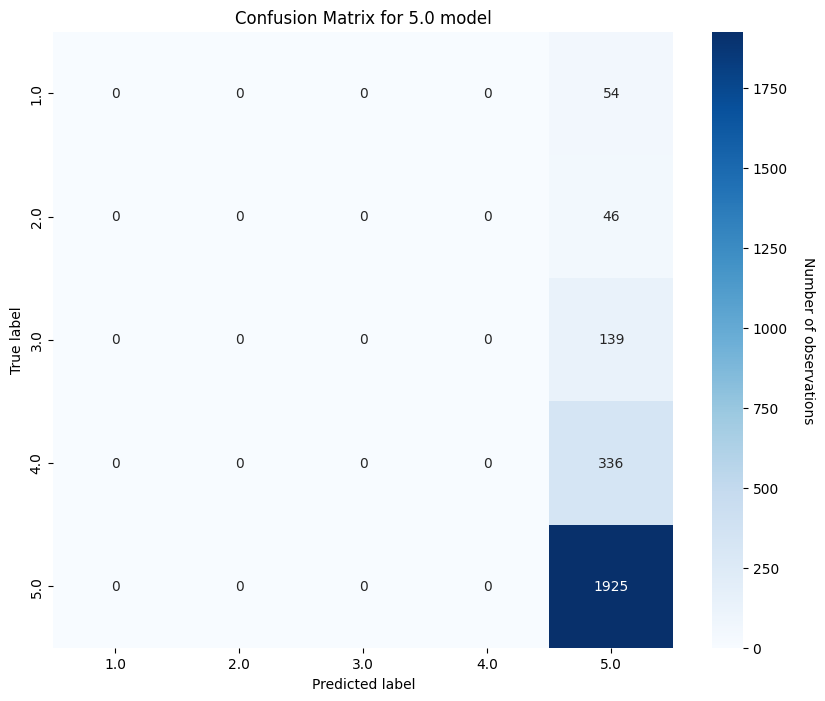

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Model:
Accuracy on Training: 0.82
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       815
         2.0       0.00      0.00      0.00       941
         3.0       0.00      0.00      0.00      5921
         4.0       0.00      0.00      0.00     32189
         5.0       0.82      1.00      0.90    183336

    accuracy                           0.82    223202
   macro avg       0.16      0.20      0.18    223202
weighted avg       0.67      0.82      0.74    223202

------------------------------------------------------------
Model:
Accuracy on Testing: 0.77
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        54
         2.0       0.00      0.00      0.00        46
         3.0       0.00      0.00      0.00       139
         4.0       0.00      0.00      0.00       336
         5.0       0.77      1.00      0.87      1925

    accuracy                           0.77      2500
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [151]:
train_and_evaluate_final_model_constant(X_final_train_scaled, y_final_train, X_final_test_scaled, y_final_test, 5.0)